## Preprocessing

In [1]:
import os
import pandas as pd
import numpy as np
import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import plot_importance
import lightgbm as lgb
from lightgbm import LGBMClassifier
from sklearn.preprocessing import LabelEncoder
import shap
import matplotlib.pyplot as plt
import tqdm
from timeit import default_timer as timer

from sklearn import metrics
from sklearn.model_selection import LeaveOneOut
from sklearn.inspection import permutation_importance
from sklearn.model_selection import cross_validate

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [2]:
os.chdir('c:/users/fre_f/pythonprojects/bacteriological/')

In [3]:
df = pd.read_csv('./data/final/03_family_desl_ra.csv')

In [4]:
df.head()

,Index,DESL,Corynebacteriaceae,Staphylococcaceae,Propionibacteriaceae,Neisseriaceae,Moraxellaceae,Lachnospiraceae,Family XI,Lactobacillaceae,...,Monopoex (Y_N),Artifical tears,Light treatment,TBUT OD,TBUT OS,OSS OD,OSS OS,ST OD,ST OS,Demodicosis
0,P1,3,0.092816,0.001058,0.042075,0.0,0.006020,0.092352,0.0,0.000000,...,1,0,0,3,3,0,0,23,23,0
1,P2,3,0.698862,0.001191,0.004366,0.0,0.000000,0.012305,0.0,0.000000,...,1,1,0,2,4,1,3,14,18,0
2,P3,2,0.034017,0.259365,0.003640,0.0,0.000000,0.088352,0.0,0.013501,...,0,1,1,8,8,3,3,11,8,0
3,P4,3,0.029042,0.177362,0.015877,0.0,0.000000,0.127216,0.0,0.003109,...,0,1,0,3,2,2,2,12,11,0
4,P5,1,0.308125,0.164086,0.050351,0.0,0.004896,0.018195,0.0,0.000000,...,1,1,1,11,11,0,0,22,32,0


In [5]:
df.iloc[:,2:155]

,Corynebacteriaceae,Staphylococcaceae,Propionibacteriaceae,Neisseriaceae,Moraxellaceae,Lachnospiraceae,Family XI,Lactobacillaceae,Carnobacteriaceae,Micrococcaceae,...,Cellvibrionaceae,*Lariskella,Boechera gunnisoniana,Myrmecia israelensis,Acidimicrobiaceae,Nitrospiraceae,Methylophilaceae,Parachlamydiaceae,Salinisphaeraceae,Sporichthyaceae
0,0.092816,0.001058,0.042075,0.000000,0.006020,0.092352,0.000000,0.000000,0.053850,0.000000,...,0,0,0,0,0,0,0.0,0,0.0,0
1,0.698862,0.001191,0.004366,0.000000,0.000000,0.012305,0.000000,0.000000,0.001985,0.000000,...,0,0,0,0,0,0,0.0,0,0.0,0
2,0.034017,0.259365,0.003640,0.000000,0.000000,0.088352,0.000000,0.013501,0.004964,0.032363,...,0,0,0,0,0,0,0.0,0,0.0,0
3,0.029042,0.177362,0.015877,0.000000,0.000000,0.127216,0.000000,0.003109,0.053056,0.006946,...,0,0,0,0,0,0,0.0,0,0.0,0
4,0.308125,0.164086,0.050351,0.000000,0.004896,0.018195,0.000000,0.000000,0.118698,0.000265,...,0,0,0,0,0,0,0.0,0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56,0.358462,0.185519,0.108214,0.016877,0.003177,0.090807,0.011847,0.000000,0.000000,0.000000,...,0,0,0,0,0,0,0.0,0,0.0,0
57,0.114117,0.355253,0.048227,0.000000,0.005094,0.040487,0.000000,0.000000,0.046110,0.000000,...,0,0,0,0,0,0,0.0,0,0.0,0
58,0.296309,0.601019,0.004895,0.000000,0.000000,0.004631,0.001257,0.000000,0.000000,0.000000,...,0,0,0,0,0,0,0.0,0,0.0,0
59,0.839706,0.046375,0.005028,0.000000,0.006285,0.017465,0.000000,0.000000,0.000000,0.000728,...,0,0,0,0,0,0,0.0,0,0.0,0


In [6]:
df.iloc[:,1]

0     3
1     3
2     2
3     3
4     1
     ..
56    3
57    2
58    2
59    2
60    3
Name: DESL, Length: 61, dtype: int64

In [7]:
X = df.iloc[:,2:155]
y = df.iloc[:,1]

## Cross validate with leave one out and explain according to average of estimators

### XGBoost

In [8]:
le = LabelEncoder()
y_xgb = le.fit_transform(y)


clfxgb = XGBClassifier(random_state=42)
looxgb = LeaveOneOut()
xgb_scores = cross_validate(clfxgb, X, y_xgb, cv=looxgb, scoring='accuracy', return_estimator=True)


In [ ]:
xgb_scores

In [ ]:
feature_importances_complete = []

for idx, estimator in enumerate(xgb_scores['estimator']):
    print(f'The most important features for estimator {idx}:')
    feature_importances = pd.DataFrame(estimator.feature_importances_,
                                       index=X.columns,
                                       columns=['Importance']).sort_values('Importance', ascending=False)
    print(feature_importances)
    feature_importances_complete.append(feature_importances)

feature_importances_complete = pd.concat(feature_importances_complete)

In [11]:
feature_importances_complete

,Importance
Nitriliruptoraceae,0.101516
Halomonadaceae,0.061932
Pasteurellaceae,0.052432
Veillonellaceae,0.051244
Acidaminococcaceae,0.046129
...,...
Chromatiaceae,0.000000
Rikenellaceae,0.000000
Geobacteraceae,0.000000
Erysipelotrichaceae,0.000000


In [12]:
feature_importances_complete.shape

(9333, 1)

In [13]:
fic = feature_importances_complete.groupby(level=0).mean().sort_values('Importance', ascending=False)

In [14]:
fic[:15]

,Importance
Nitriliruptoraceae,0.098271
Rhizobiaceae,0.055844
Pasteurellaceae,0.053902
Family XII,0.053842
Acidaminococcaceae,0.043944
Halomonadaceae,0.039410
Oxalobacteraceae,0.038210
Microbacteriaceae,0.032851
Aerococcaceae,0.029468
Bacillaceae,0.028845


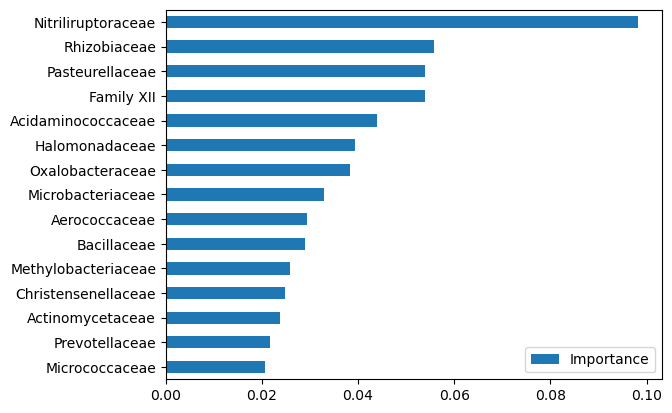

In [15]:
plot_fic = fic[:15]
plot_fic.plot(kind='barh').invert_yaxis()

In [ ]:
for estimator in xgb_scores['estimator']:
    explainerxgb = shap.Explainer(estimator, X)
    shap_valuesxgb = explainerxgb.shap_values(X)

In [17]:
np.shape(shap_valuesxgb)

(4, 61, 153)

In [18]:
shap_valuesxgb_mean = np.mean(shap_valuesxgb, axis=1)

In [19]:
np.shape(shap_valuesxgb_mean)

(4, 153)

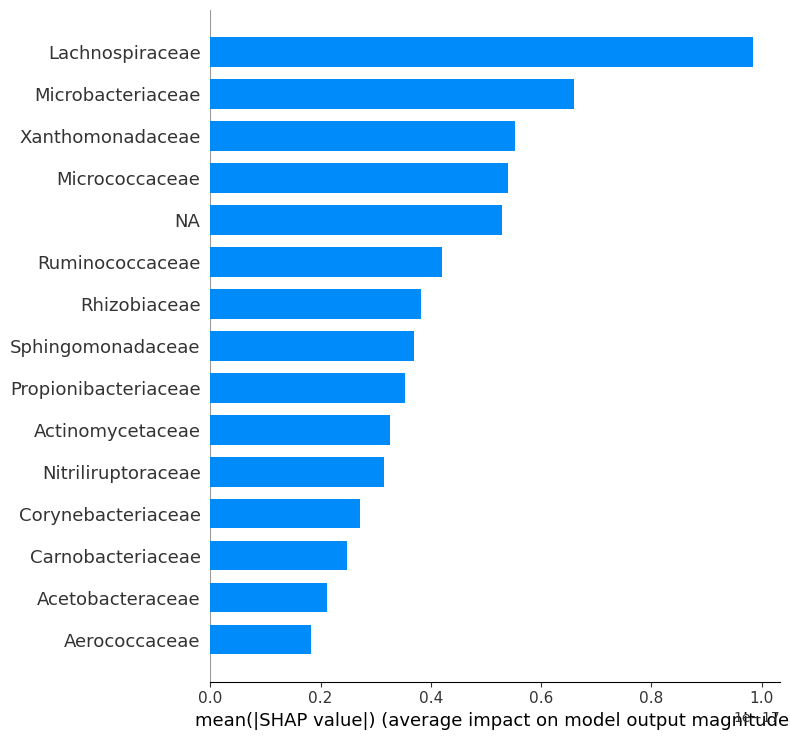

In [20]:
shap.summary_plot(shap_valuesxgb_mean, X, plot_type='bar', max_display=15)

### LightGBM

In [ ]:
clflgbm = LGBMClassifier(random_state=42)
loolgbm = LeaveOneOut()
lgbm_scores = cross_validate(clflgbm, X, y, cv=loolgbm, scoring='accuracy', return_estimator=True)

In [ ]:
lgbm_scores

In [ ]:
feature_importances_complete_lgb = []

for idx, estimator in enumerate(lgbm_scores['estimator']):
    print(f'The most important features for estimator {idx}:')
    feature_importances_lgb = pd.DataFrame(estimator.feature_importances_,
                                       index=X.columns,
                                       columns=['Importance']).sort_values('Importance', ascending=False)
    print(feature_importances_lgb)
    feature_importances_complete_lgb.append(feature_importances_lgb)

feature_importances_complete_lgb = pd.concat(feature_importances_complete_lgb)

In [24]:
feature_importances_complete_lgb

,Importance
Lachnospiraceae,45
Micrococcaceae,43
Xanthomonadaceae,43
NA,37
Pseudomonadaceae,37
...,...
Halomonadaceae,0
Cellulomonadaceae,0
Dermacoccaceae,0
Dietziaceae,0


In [25]:
fic_lgb = feature_importances_complete_lgb.groupby(level=0).mean().sort_values('Importance', ascending=False)

In [26]:
fic_lgb[:15]

,Importance
Lachnospiraceae,45.475410
Xanthomonadaceae,44.327869
Propionibacteriaceae,41.557377
NA,39.803279
Micrococcaceae,38.524590
Pseudomonadaceae,37.852459
Sphingomonadaceae,34.803279
Ruminococcaceae,34.737705
Microbacteriaceae,29.557377
Moraxellaceae,26.081967


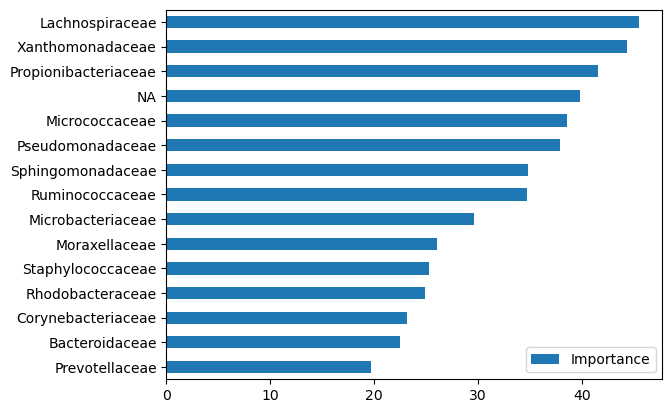

In [27]:
plot_fic_lgb = fic_lgb[:15]
plot_fic_lgb.plot(kind='barh').invert_yaxis()

In [28]:
for estimator in lgbm_scores['estimator']:
    explainerlgb = shap.Explainer(estimator, X)
    shap_valueslgb = explainerlgb.shap_values(X)    
    

In [29]:
np.shape(shap_valueslgb)

(4, 61, 153)

In [30]:
shap_valueslgb_mean = np.mean(shap_valueslgb, axis=1)

In [31]:
np.shape(shap_valueslgb_mean)

(4, 153)

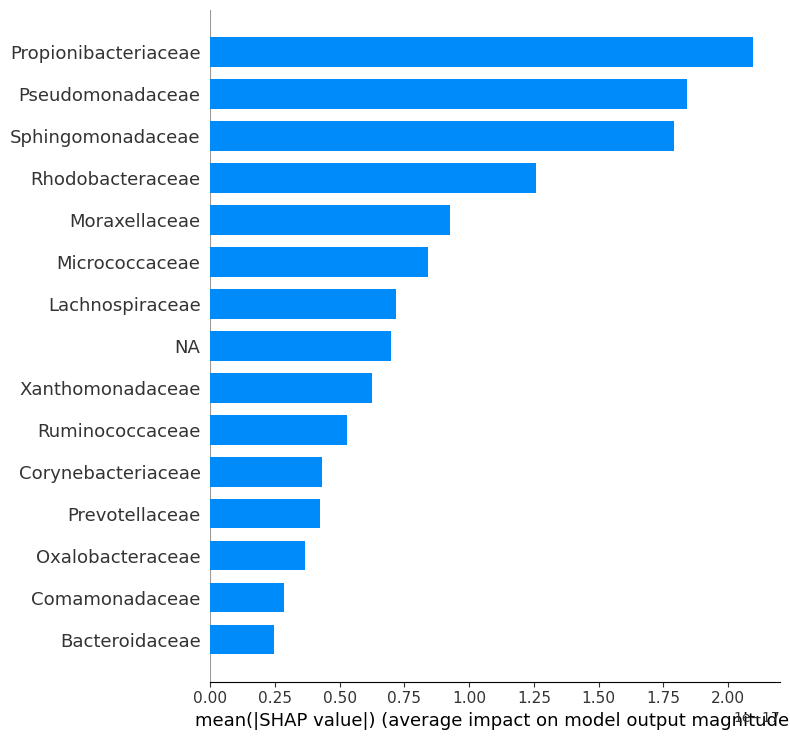

In [32]:
shap.summary_plot(shap_valueslgb_mean, X, plot_type='bar', max_display=15)

### Multilayer perceptron 

In [33]:
from sklearn.neural_network import MLPClassifier
clfmlp = MLPClassifier(solver="adam", activation="relu", learning_rate="constant", random_state=42, max_iter=30000, verbose=False)
clfmlp.out_activation_="softmax"

loomlp = LeaveOneOut()
mlp_scores = cross_validate(clfmlp, X, y, cv=loomlp, scoring='accuracy', return_estimator=True)

In [ ]:
mlp_scores

In [ ]:
# Every estimator in mlp_scores need to be fitted and permutation importance run on each estimator.
MLP_feature_importances_complete = []

for idx, estimator in enumerate(mlp_scores['estimator']):
    mlpimportance = estimator.fit(X, y)
    result = permutation_importance(mlpimportance,X, y,n_repeats=20, random_state = 42)
    MLPfeatures = pd.DataFrame(mlpimportance.feature_names_in_,columns=['Features'])
    MLPfeatures['Importance'] = result.importances_mean.tolist()
    #Sort by importance
    MLPfeatures = MLPfeatures.sort_values(by = 'Importance',ascending=False)
    print(f'The most important features for estimator {idx}:')
    print(MLPfeatures)
    MLP_feature_importances_complete.append(MLPfeatures)

MLP_feature_importances_complete = pd.concat(MLP_feature_importances_complete)

In [36]:
MLPfeatures.shape

(153, 2)

In [37]:
MLP_feature_importances_complete.shape

(9333, 2)

In [38]:
fic_mlp = MLP_feature_importances_complete.groupby('Features').mean().sort_values('Importance', ascending=False)

In [39]:
fic_mlp.shape

(153, 1)

In [40]:
fic_mlp[:15]

,Importance
Features,
Neisseriaceae,0.045082
Carnobacteriaceae,0.042623
Corynebacteriaceae,0.037705
Lachnospiraceae,0.033607
Rhodobacteraceae,0.032787
NA,0.029508
Pseudomonadaceae,0.025410
Staphylococcaceae,0.022951
Micrococcaceae,0.021311


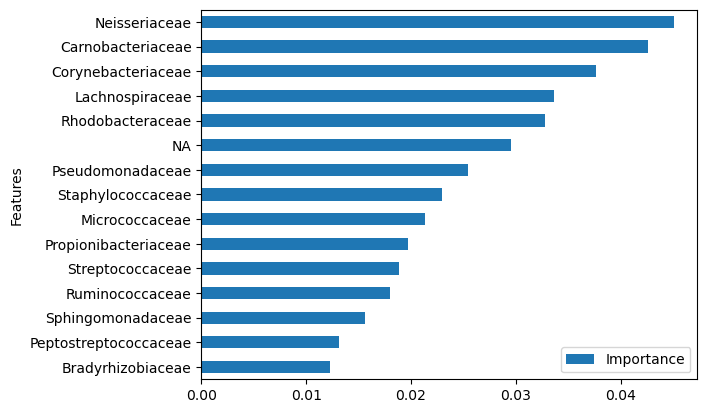

In [41]:
plot_fic_mlp = fic_mlp[:15]
plot_fic_mlp.plot(kind='barh').invert_yaxis()

In [42]:
for estimator in mlp_scores['estimator']:
    explainermlp = shap.Explainer(mlpimportance.predict, X)
    shap_valuesmlp = explainermlp.shap_values(X)

In [43]:
np.shape(shap_valuesmlp)

(61, 153)

In [44]:
shap_valuesmlp

array([[ 0.00983607,  0.0147541 ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.01803279,  0.02622951,  0.04590164, ...,  0.        ,
         0.        ,  0.        ],
       [-0.01311475,  0.00327869, -0.00983607, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-0.11639344, -0.0442623 ,  0.01639344, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.03114754, -0.03934426,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.06065574, -0.00163934, -0.05081967, ...,  0.        ,
         0.        ,  0.        ]])

In [45]:
shap_valuesmlp_mean = np.mean(shap_valuesmlp, axis=0, keepdims=True)

In [46]:
np.shape(shap_valuesmlp_mean)

(1, 153)

In [ ]:
shap_valueslgb_mean

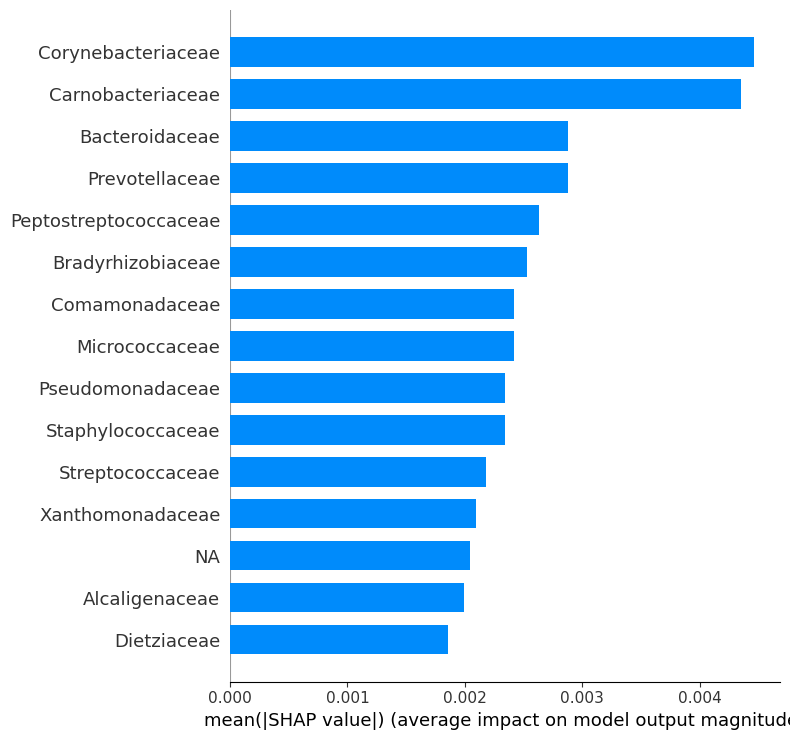

In [48]:
shap.summary_plot(shap_valuesmlp_mean, X, plot_type='bar', max_display=15)